In [1]:
from itertools import cycle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
from matplotlib import transforms
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

import common

## Load the data and get some high level statistics

In [2]:
df = pd.read_csv('data/interim/final_paths_ordered.csv')
df

,Level 1,Level 2,Level 3,Level 4,Level 5,Level 6,Level 7,Relative Strength
0,______,A_____,AA____,AAT___,AATT__,AATTT_,AATTTA,0.1190
1,______,A_____,AA____,AAT___,AATT__,AATT_T,AATTCT,0.1175
2,______,A_____,AA____,AAT___,AAT_C_,AATTC_,AATTCA,0.1068
3,______,A_____,AA____,AA_T__,AA_TT_,AA_TTA,AACTTA,0.1186
4,______,A_____,AA____,AA__C_,AA__CC,AAA_CC,AAATCC,0.1145
...,...,...,...,...,...,...,...,...
4091,______,_____T,____TT,_C__TT,_C_GTT,_CAGTT,CCAGTT,0.0814
4092,______,_____T,____TT,__C_TT,G_C_TT,GCC_TT,GCCATT,0.1043
4093,______,_____T,____TT,__C_TT,G_C_TT,G_CTTT,GTCTTT,0.1011
4094,______,_____T,____TT,__C_TT,_CC_TT,CCC_TT,CCCATT,0.1098


In [3]:
# Count the number of rows where 'Level 1' contains certain nucleotide
countA = df[df['Level 2'].str.contains('A')].shape[0]
countG = df[df['Level 2'].str.contains('G')].shape[0]
countC = df[df['Level 2'].str.contains('C')].shape[0]
countT = df[df['Level 2'].str.contains('T')].shape[0]

print("Number of rows where 'Level 2' is 'A':", countA)
print("Number of rows where 'Level 2' is 'G':", countG)
print("Number of rows where 'Level 2' is 'C':", countC)
print("Number of rows where 'Level 2' is 'T':", countT)

Number of rows where 'Level 2' is 'A': 409
Number of rows where 'Level 2' is 'G': 2464
Number of rows where 'Level 2' is 'C': 573
Number of rows where 'Level 2' is 'T': 650


In [4]:
# Get the number of row, where Level 2 contains G and Level 3 contains two Gs
countGG = df[(df['Level 2'].str.contains('G')) & (df['Level 3'].str.count('G') == 2)].shape[0]
print("Number of rows where 'Level 1' contains 'G' and 'Level 2' contains two 'G's:", countGG)

# Get the number of row, where Level 2 contains C and Level 3 contains C and A
countCA = df[(df['Level 2'].str.contains('C')) & (df['Level 3'].str.contains('C')) & (df['Level 3'].str.contains('A'))].shape[0]
print("Number of rows where 'Level 1' contains 'C' and 'Level 2' contains 'C' and 'A':", countCA)

Number of rows where 'Level 1' contains 'G' and 'Level 2' contains two 'G's: 1072
Number of rows where 'Level 1' contains 'C' and 'Level 2' contains 'C' and 'A': 81


## Plot the counts for each nucleotide

In [5]:
# From the df, get only columns 'Level 2' and 'Level 3'
df_count = df[['Level 2', 'Level 3']]

def plot_dinucleotide_donut(df):
    """
    Create a donut chart from a pandas DataFrame with columns 'Level 2' and 'Level 3'.
    - 'Level 2': string of length 6 with one nucleotide between underscores (determines color and first position).
    - 'Level 3': string of length 6 with two nucleotides between underscores (defines both letters).
    The resulting dinucleotide is arranged as <Level2_base><other_nucleotide>.
    Labels are in the format <Level2>_<Dinucleotide> (count).
    """
    # Copy to avoid modifying original
    df_copy = df.copy()

    # Extract single base and full pair
    df_copy['Base'] = df_copy['Level 2'].str.replace('_', '', regex=False)
    full_pair = df_copy['Level 3'].str.replace('_', '', regex=False)

    # Construct dinucleotide based on Level 2 base first
    def make_dinuc(base, pair):
        other = pair.replace(base, '', 1)
        return base + other

    df_copy['Dinucleotide'] = [make_dinuc(b, p) for b, p in zip(df_copy['Base'], full_pair)]

    # Count occurrences
    counts = df_copy['Dinucleotide'].value_counts().rename_axis('Dinucleotide').reset_index(name='Count')

    # Assign colors by base
    color_map = {'A': 'blue', 'C': 'orange', 'G': 'green', 'T': 'red'}
    counts['Base'] = counts['Dinucleotide'].str[0]
    counts['Color'] = counts['Base'].map(color_map)

    # Sort for contiguous color groups
    counts = counts.sort_values(['Base', 'Dinucleotide']).reset_index(drop=True)

    # Prepare labels in 'Level2_Level3 (count)' format
    # labels = counts.apply(lambda row: f"{row['Base']}_{row['Dinucleotide']} ({row['Count']})", axis=1)
    labels = counts.apply(lambda row: f"{row['Dinucleotide']} ({row['Count']})", axis=1)
    sizes = counts['Count']
    colors = counts['Color']

    # Plot donut chart
    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, texts = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        startangle=135,
        labeldistance=1.1,
        wedgeprops=dict(width=0.4, edgecolor='white'),
        textprops={'fontsize': 15}
    )

    # Add central white circle for donut effect
    center_circle = plt.Circle((0, 0), 0.6, fc='white')
    ax.add_artist(center_circle)

    # Add legend
    legend_handles = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in color_map.values()]
    legend_labels = list(color_map.keys())
    # ax.legend(legend_handles, legend_labels,
    #       loc='lower right',
    #       bbox_to_anchor=(1.0, 0.0),
    #       fontsize=15,
    #       title='Level 2',
    #       borderaxespad=0.1)

    # Title padding
    # ax.set_title('Nucleotides Frequency in Level 2 and Level 3', pad=20)
    plt.tight_layout()
    ax.axis('equal')

    # Save the plot as an eps file
    plt.savefig('levels_pie_chart.eps',
            format='eps',
            dpi=300,
            bbox_inches='tight')

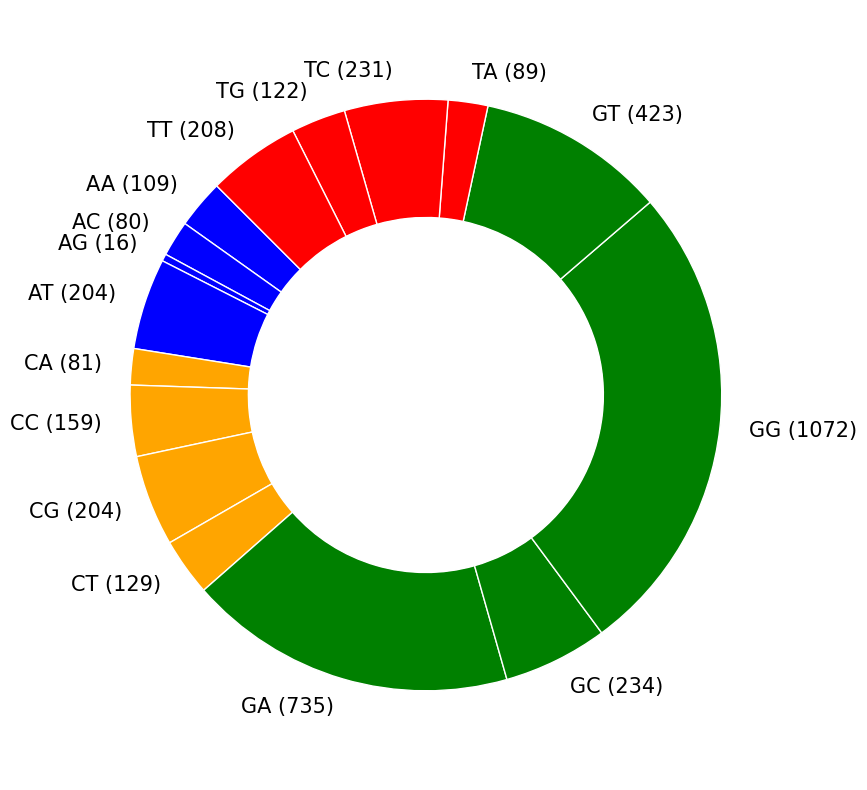

In [6]:
plot_dinucleotide_donut(df_count)

## Remove the Level 1 and (optionally) set some minimal threshold for the Relative Strength or other filters

In [7]:
THRESHOLD = 0.25
df = df.drop(columns=['Level 1'])
# df = df[df['Relative Strength'] >= THRESHOLD]

## One-hot encoding

### Encode the sequences

In [8]:
# Function to one-hot encode a single sequence
def one_hot_encode(sequence, characters):
    char_to_int = dict((c, i) for i, c in enumerate(characters))
    integer_encoded = [char_to_int[char] for char in sequence]
    onehot_encoded = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(characters))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded).flatten()

# Apply the encoding to each column in the dataframe and preserve column names
encoded_columns = []
for col in df.columns[:-1]:  # Exclude 'Relative Strength' column for encoding
    encoded_sequences = df[col].apply(lambda x: one_hot_encode(x, common.POSSIBLE_CHARACTERS))
    col_encoded_df = pd.DataFrame(encoded_sequences.tolist(), columns=[f"{col}_{i}" for i in range(encoded_sequences.iloc[0].size)])
    encoded_columns.append(col_encoded_df)

# Concatenate all encoded columns into a single dataframe
encoded_df = pd.concat(encoded_columns, axis=1)

### Encode the relative strength value

In [9]:
# Add index as a column for clustering
encoded_df['index'] = df.index
encoded_df['Relative Strength'] = df['Relative Strength']

# Encode the relative strength
NUMBER_OF_COLUMNS_FOR_STRENGTH = 200

# Function to convert a value to a binary list with 200 columns
def value_to_binary_list(value, length=NUMBER_OF_COLUMNS_FOR_STRENGTH):
    ones_count = int(round(value, 2) * NUMBER_OF_COLUMNS_FOR_STRENGTH)
    return [1] * ones_count + [0] * (length - ones_count)

# Apply the function to create binary columns
binary_columns = df['Relative Strength'].apply(value_to_binary_list)

# Create a DataFrame from the binary columns
binary_df = pd.DataFrame(binary_columns.tolist(), columns=[f'rel_strength_{i+1}' for i in range(NUMBER_OF_COLUMNS_FOR_STRENGTH)])

encoded_df = pd.concat([encoded_df, binary_df], axis=1)

encoded_df

,Level 2_0,Level 2_1,Level 2_2,Level 2_3,Level 2_4,Level 2_5,Level 2_6,Level 2_7,Level 2_8,Level 2_9,...,rel_strength_191,rel_strength_192,rel_strength_193,rel_strength_194,rel_strength_195,rel_strength_196,rel_strength_197,rel_strength_198,rel_strength_199,rel_strength_200
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4092,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4093,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4094,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## DBSCAN

In [10]:
# Perform DBSCAN
number_of_clusters = 1000
current_eps = 5.9

# current_eps = 0.1 # For mahalanobis

while number_of_clusters > 400:
    # db = DBSCAN(eps=current_eps, min_samples=1, metric='mahalanobis', metric_params={'VI':np.cov(encoded_df)}, algorithm='brute', leaf_size=30, n_jobs=-1)
    db = DBSCAN(eps=current_eps, min_samples=1, leaf_size=30, n_jobs=6)
    clusters = db.fit_predict(encoded_df)
    unique_clusters = set(clusters)
    number_of_clusters = len(unique_clusters)
    print(f'For eps = {current_eps}, the number of clusters is {len(unique_clusters)}')
    current_eps += 0.05

# Add cluster labels to the DataFrame
encoded_df['CLUSTER'] = clusters

For eps = 5.9, the number of clusters is 481
For eps = 5.95, the number of clusters is 442
For eps = 6.0, the number of clusters is 442
For eps = 6.05, the number of clusters is 419
For eps = 6.1, the number of clusters is 381


### Save the dataframe

In [11]:
encoded_df['SEQ'] = df['Level 7']
encoded_df['CORE REL EXPR'] = df['Relative Strength']
encoded_df.to_csv('data/interim/dbscan_clusters_df.csv', index=False)

### Visualization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


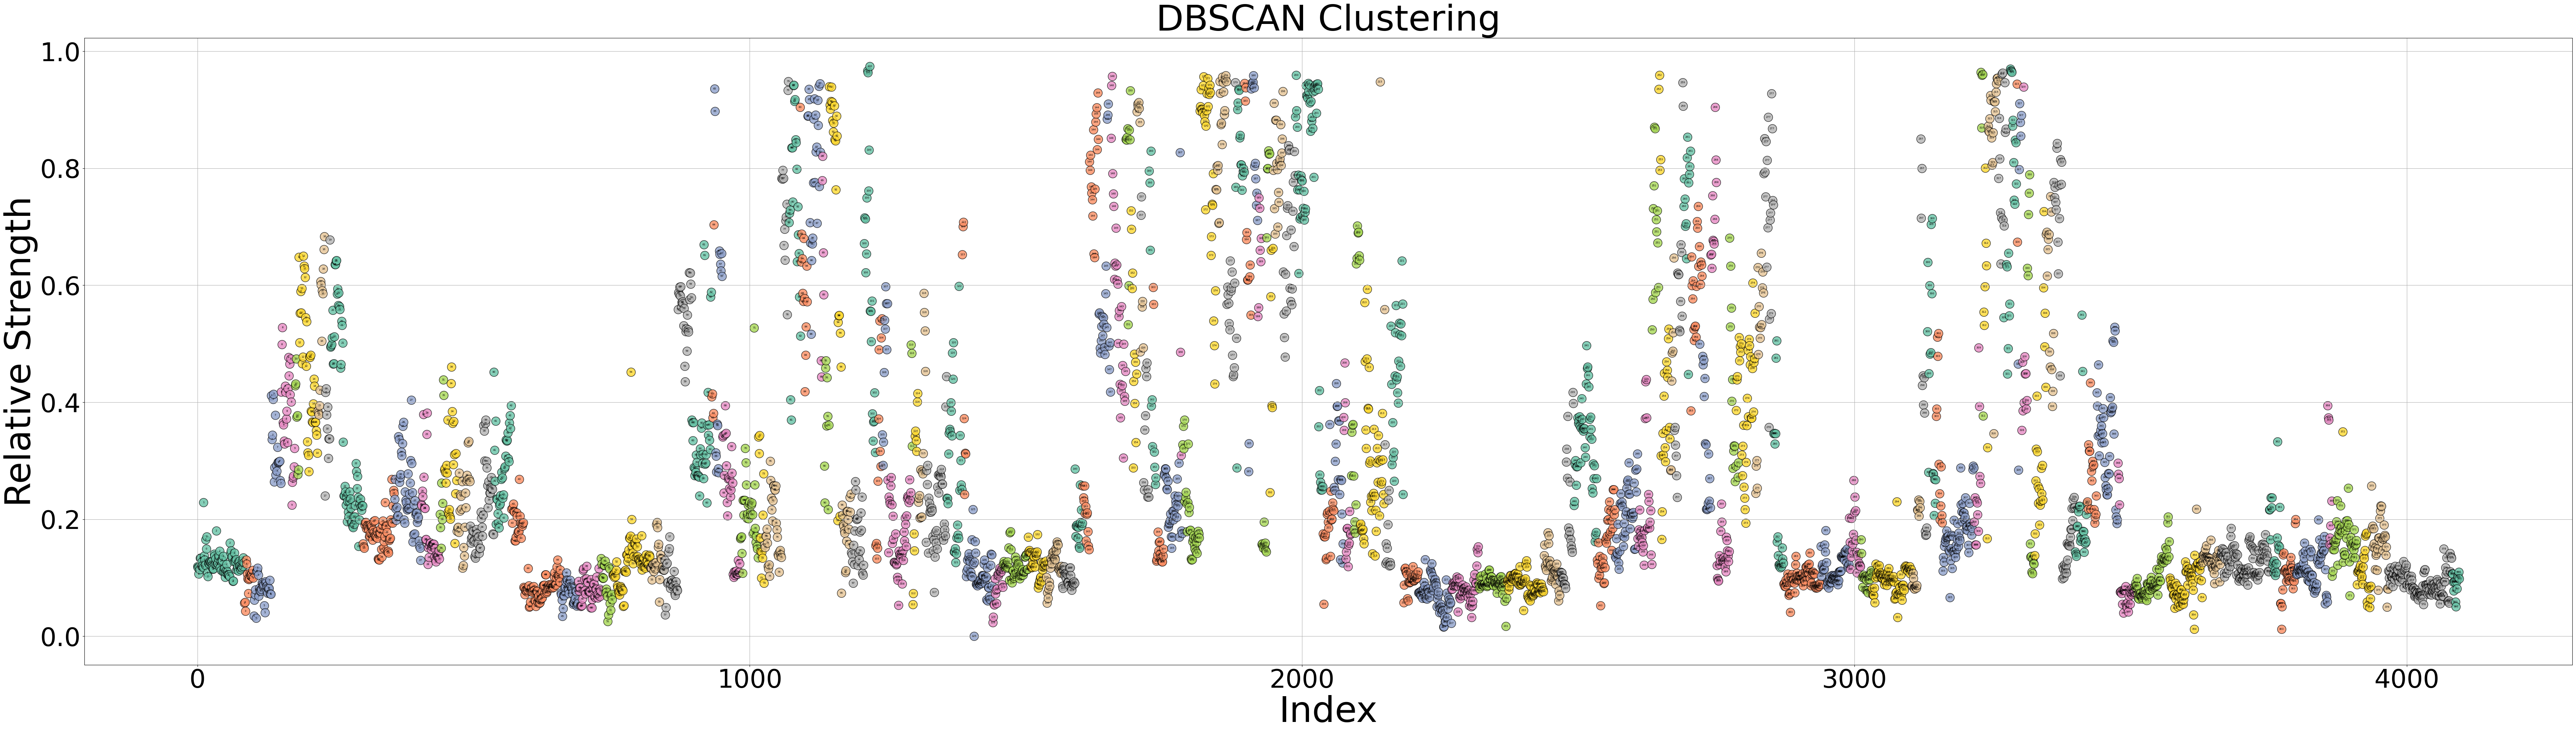

In [12]:
# Create a color cycle from a colormap
color_cycle = cycle(cm.Set2(np.linspace(0, 1, 20)))

# Map each unique cluster to a color
color_map = {cluster: next(color_cycle) for cluster in unique_clusters}

# Visualization
plt.figure(figsize=(70, 20))

for cluster in unique_clusters:
    color = color_map[cluster]
    cluster_mask = clusters == cluster
    plt.scatter(encoded_df.index[cluster_mask], encoded_df['Relative Strength'][cluster_mask], 
                color=color, label=f'Cluster {cluster}', s=280, edgecolor='k', alpha=0.8)
    # Add cluster number inside each circle
    for idx in encoded_df.index[cluster_mask]:
        plt.text(idx, encoded_df['Relative Strength'][idx], str(cluster), # str(idx), 
                 color='black', fontsize=5, ha='center', va='center')

# Highlight noise points (if any)
noise_mask = clusters == -1
plt.scatter(encoded_df.index[noise_mask], encoded_df['Relative Strength'][noise_mask], 
            color='red', label='Noise', s=180, marker='x')

# Add the x and y labels, plot title and make it large
plt.xlabel('Index', fontsize=70)
plt.ylabel('Relative Strength', fontsize=70)
plt.title('DBSCAN Clustering', fontsize=70)

# Make also large the tick labels
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)

plt.grid(True)
plt.tight_layout()

# Save the plot as an eps file
plt.savefig('dbscan_clustering_plot.eps',
            format='eps',
            dpi=300,
            bbox_inches='tight')

## Create a final dataframe with clusters their mean and CV

In [13]:
# From the encoded_df, use only columns 'CLUSTER', 'SEQ' and 'CORE REL EXPR'
df = encoded_df[['CLUSTER', 'SEQ', 'CORE REL EXPR']]

# Group by cluster, calculate the mean and std for each cluster and add all SEQs to the dataframe
df_grouped = df.groupby('CLUSTER').agg({'CORE REL EXPR': ['mean', 'std'], 'SEQ': 'unique'}).reset_index()
# Remove the line breaks from the header
df_grouped.columns = df_grouped.columns.map('_'.join)
# Remove the line breaks from the SEQ_unique values
df_grouped['SEQ_unique'] = df_grouped['SEQ_unique'].apply(lambda x: ','.join(x))
df_grouped

,CLUSTER_,CORE REL EXPR_mean,CORE REL EXPR_std,SEQ_unique
0,0,0.129612,0.017409,"AATTTA,AATTCT,AATTCA,AACTTA,AAATCC,AATATG,AATA..."
1,1,0.229000,NaN,ATCCGC
2,2,0.123416,0.014622,"ACCTAC,ACCTCC,ACATCC,ACATCA,ACATAC,AAATCA,ATAT..."
3,3,0.052767,0.008386,"CGTTCC,CGTCCC,CGTCAC"
4,4,0.104843,0.013261,"CCGAAA,CCGAAT,CCGTGA,CTGCCT,CCGGAC,CAAGTC,CCGG..."
...,...,...,...,...
376,376,0.070700,0.018187,"CATCCG,TCACCG,TCCCCG"
377,377,0.103400,0.011403,"ACTCGT,ACACCT,ACCTTT,ACATCT,CCCTAT,CCCCCT,CCAA..."
378,378,0.081756,0.017708,"ACCAGT,ACCCAT,ATCCCT,AACAAT,CCCAAT,TCCCAT,GCCC..."
379,379,0.130325,0.013597,"ACTAGT,CCAAGT,ATCAGT,CACAGT"


In [14]:
df_grouped.to_csv('data/processed/clusters_with_stats.csv', index=False)

### Create logo plots

In [15]:
# Define the function
def create_logo(sequences, filename=None):
    """
    Create a logo plot from a list of sequences.

    Args:
        sequences (list): A list of sequences to plot.

    Returns:
        None
    """

    # Calculate frequencies at each position
    L = len(sequences[0])
    counts = [dict(A=0, C=0, G=0, T=0) for _ in range(L)]
    for seq in sequences:
        for i, nt in enumerate(seq):
            counts[i][nt] += 1

    max_count = len(sequences)

    # Set up figure
    fig, ax = plt.subplots(figsize=(8, 4))
    fp = FontProperties(family="DejaVu Sans", weight="bold")

    # Draw logo
    for pos in range(L):
        y_offset = 0
        # sort by frequency (smallest first so largest letters on top)
        for nt, cnt in sorted(counts[pos].items(), key=lambda x: x[1]):
            if cnt > 0:
                # Create the letter path
                tp = TextPath((0, 0), nt, prop=fp, size=1)
                # Scale height by relative frequency
                scale = cnt / max_count
                trans = (transforms.Affine2D()
                         .scale(1, scale)
                         .translate(pos + 0.2, y_offset)
                         + ax.transData)
                patch = PathPatch(tp, transform=trans)
                ax.add_patch(patch)
                y_offset += scale

    # Formatting
    ax.set_xlim(0, L)
    ax.set_ylim(0, 1)
    ax.set_xticks([i + 0.5 for i in range(L)])
    ax.set_xticklabels([str(i + 1) for i in range(L)])
    ax.set_yticks([])
    # ax.set_xlabel("Position")
    # ax.set_title("Sequence Logo of Provided DNA Sequences")

    plt.tight_layout()

    if filename:
        # Save the plot as an eps file
        plt.savefig(filename,
                format='eps',
                dpi=300,
                bbox_inches='tight')
    else:
        plt.show()

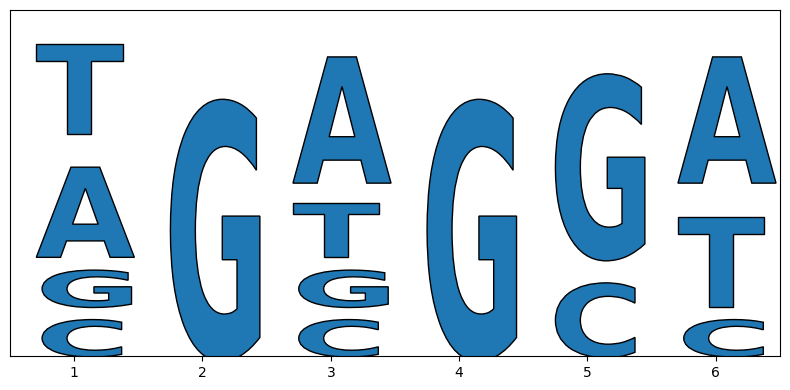

In [16]:
# Produce the logo plot for sequence in cluster 87
sequences = df_grouped[df_grouped['CLUSTER_'] == 87]['SEQ_unique'].str.split(',').tolist()[0]
create_logo(sequences, 'logo_plot_cluster_87.eps')

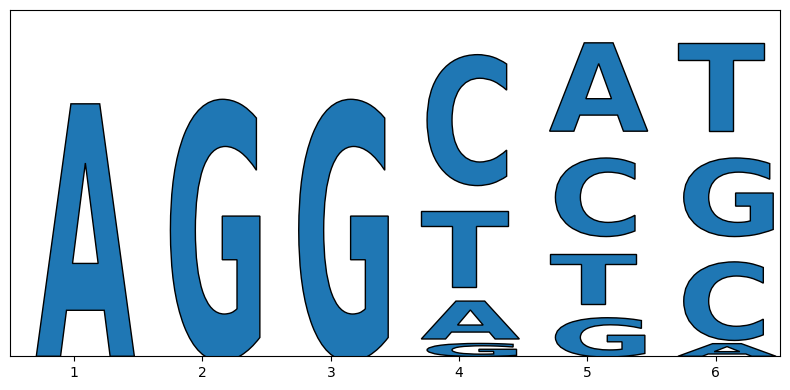

In [17]:
# Produce the logo plot for sequence in cluster 172
sequences = df_grouped[df_grouped['CLUSTER_'] == 172]['SEQ_unique'].str.split(',').tolist()[0]
create_logo(sequences, 'logo_plot_cluster_172.eps')

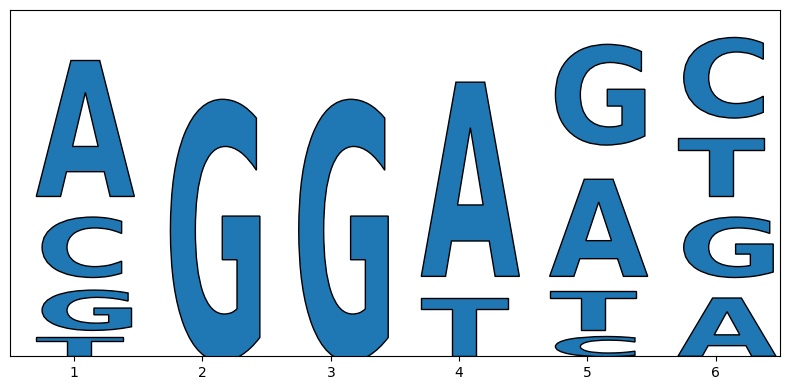

In [18]:
# Produce the logo plot for sequence in cluster 176
sequences = df_grouped[df_grouped['CLUSTER_'] == 176]['SEQ_unique'].str.split(',').tolist()[0]
create_logo(sequences)

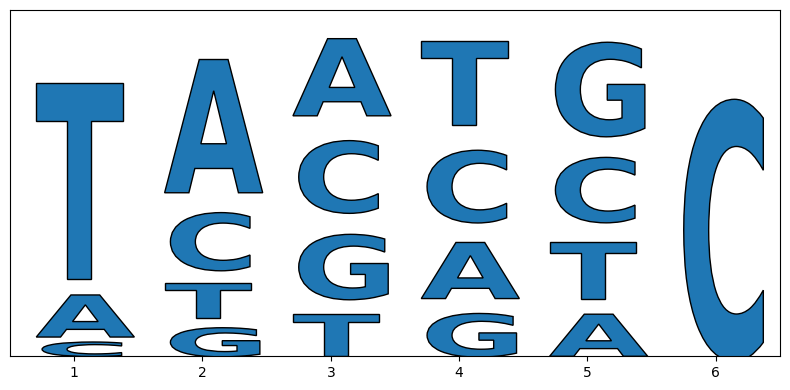

In [19]:
# Produce the logo plot for sequence in cluster 358
sequences = df_grouped[df_grouped['CLUSTER_'] == 358]['SEQ_unique'].str.split(',').tolist()[0]
create_logo(sequences, 'logo_plot_cluster_358.eps')

['AGCGAG', 'CGAGGC', 'CGGGCG', 'AGAGAG', 'AGAGCT', 'TGAGAT', 'TGAGCT', 'AGAGAA', 'AGAAGC', 'GAGCAG', 'GAGACC', 'GAGACA', 'GAGGAA', 'GAGCAA', 'GAGCCG', 'AAGGTC', 'AGGCAG', 'GGGGCT', 'AGGATC', 'AGGTAA', 'CGGGAG', 'AGGACC', 'AGGCTA', 'AGGCAA', 'GGGAAG', 'ATGGCA', 'TAGGAA', 'TGGGTA', 'AAGGAA', 'AAGGTA', 'CAGAGG', 'AAAGGT', 'AACGGT', 'TGAGGT', 'TTAGGA', 'AACGAG', 'AATAGG', 'ACGAGG', 'GGGGGA', 'CGGGGT', 'TGGAGA', 'CGGAGG', 'AGGCGA', 'CTGAGA', 'CCGAGG', 'AGGAGG']


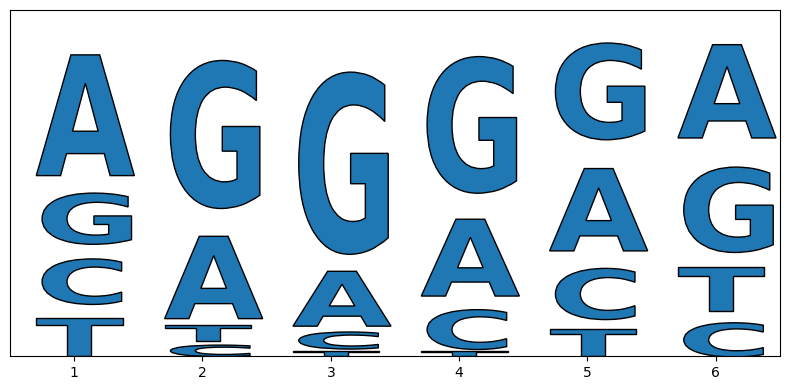

In [20]:
# Produce the logo plot for sequence in all the clusters, where the mean expression is higher than 0.8
sequences = []
filtered_df = df_grouped[df_grouped['CORE REL EXPR_mean'] > 0.75]
for index, row in filtered_df.iterrows():
    sequences.append(row['SEQ_unique'].split(',')[0])

print(sequences)
create_logo(sequences, 'logo_plot_clusters_over_075.eps')

## Show the number of singletons in df_grouped

In [21]:
df_grouped[df_grouped['SEQ_unique'].str.count(',') == 0].shape[0]

55